In [7]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

### Setting up the pyabc run

In [8]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=34, threads_per_worker = 1)
client = Client(c,timeout=90)

In [9]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'0_4_Adults_mean': 17152.0,
 '10_4_Adults_mean': 14350.0,
 '20_4_Adults_mean': 11823.0,
 '40_4_Adults_mean': 12679.0,
 '80_4_Adults_mean': 12095.0,
 '160_4_Adults_mean': 11954.0,
 '0_5_Adults_mean': 19216.0,
 '10_5_Adults_mean': 17330.0,
 '20_5_Adults_mean': 15110.0,
 '40_5_Adults_mean': 10917.0,
 '80_5_Adults_mean': 7923.0,
 '160_5_Adults_mean': 5980.0,
 '0_6_Adults_mean': 18229.0,
 '10_6_Adults_mean': 17481.0,
 '20_6_Adults_mean': 17078.0,
 '40_6_Adults_mean': 15322.0,
 '80_6_Adults_mean': 6599.0,
 '160_6_Adults_mean': 2245.0,
 '0_7_Adults_mean': 12589.0,
 '10_7_Adults_mean': 14229.0,
 '20_7_Adults_mean': 18951.0,
 '40_7_Adults_mean': 17520.0,
 '80_7_Adults_mean': 16514.0,
 '160_7_Adults_mean': 478.0,
 '0_4_Adults_sd': 3874.0,
 '10_4_Adults_sd': 5023.0,
 '20_4_Adults_sd': 4745.0,
 '40_4_Adults_sd': 5132.0,
 '80_4_Adults_sd': 4682.0,
 '160_4_Adults_sd': 3807.0,
 '0_5_Adults_sd': 4729.0,
 '10_5_Adults_sd': 3807.0,
 '20_5_Adults_sd': 5023.0,
 '40_5_Adults_sd': 4847.0,
 '80_5_Adults_sd'

In [10]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #transformed to 0.0001 - .1
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              #AIAdultLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AIAdultLD50=(-4, -1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AIAdultSlope=(1, 9),
              #AILarvaLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AILarvaLD50=(-4,-1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [11]:
# Set our distance function and sampler
#distance = pyabc.AdaptivePNormDistance(p=2, adaptive=True, scale_type=0) #scale type is MAD (more resilient to outliers)
#df_logger = logging.getLogger('DistanceFunction')
#df_logger.setLevel(logging.DEBUG)

distance = PNormDistance(p=2)

sampler = DaskDistributedSampler(dask_client = client)
#sampler = SingleCoreSampler()

#transition = LocalTransition()

In [12]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=100,#AdaptivePopulationSize(500, max_population_size = 600),
             #transitions = transition,
             sampler=sampler)

In [13]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_20.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=15, start_time=2018-11-19 17:01:59.589747, end_time=None)>
INFO:Epsilon:initial epsilon is 42685.619170830614


15

In [14]:
history = abc.run(max_nr_populations=3, minimum_epsilon=0)

INFO:ABC:t:0 eps:42685.619170830614
INFO:ABC:t:1 eps:42635.315659501684


KeyboardInterrupt: 

In [17]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-19 17:02:06.982586,0,0.000000,1
1,0,2018-11-19 23:29:19.529288,209,42685.619171,100


In [ ]:
#get acceptance rates for each generation
print("Acceptance rates:")
for samples, particles in zip(pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("{:.1f}".format(particles/samples*100))

In [ ]:
history.get_distribution(m=0)

### Visualize results

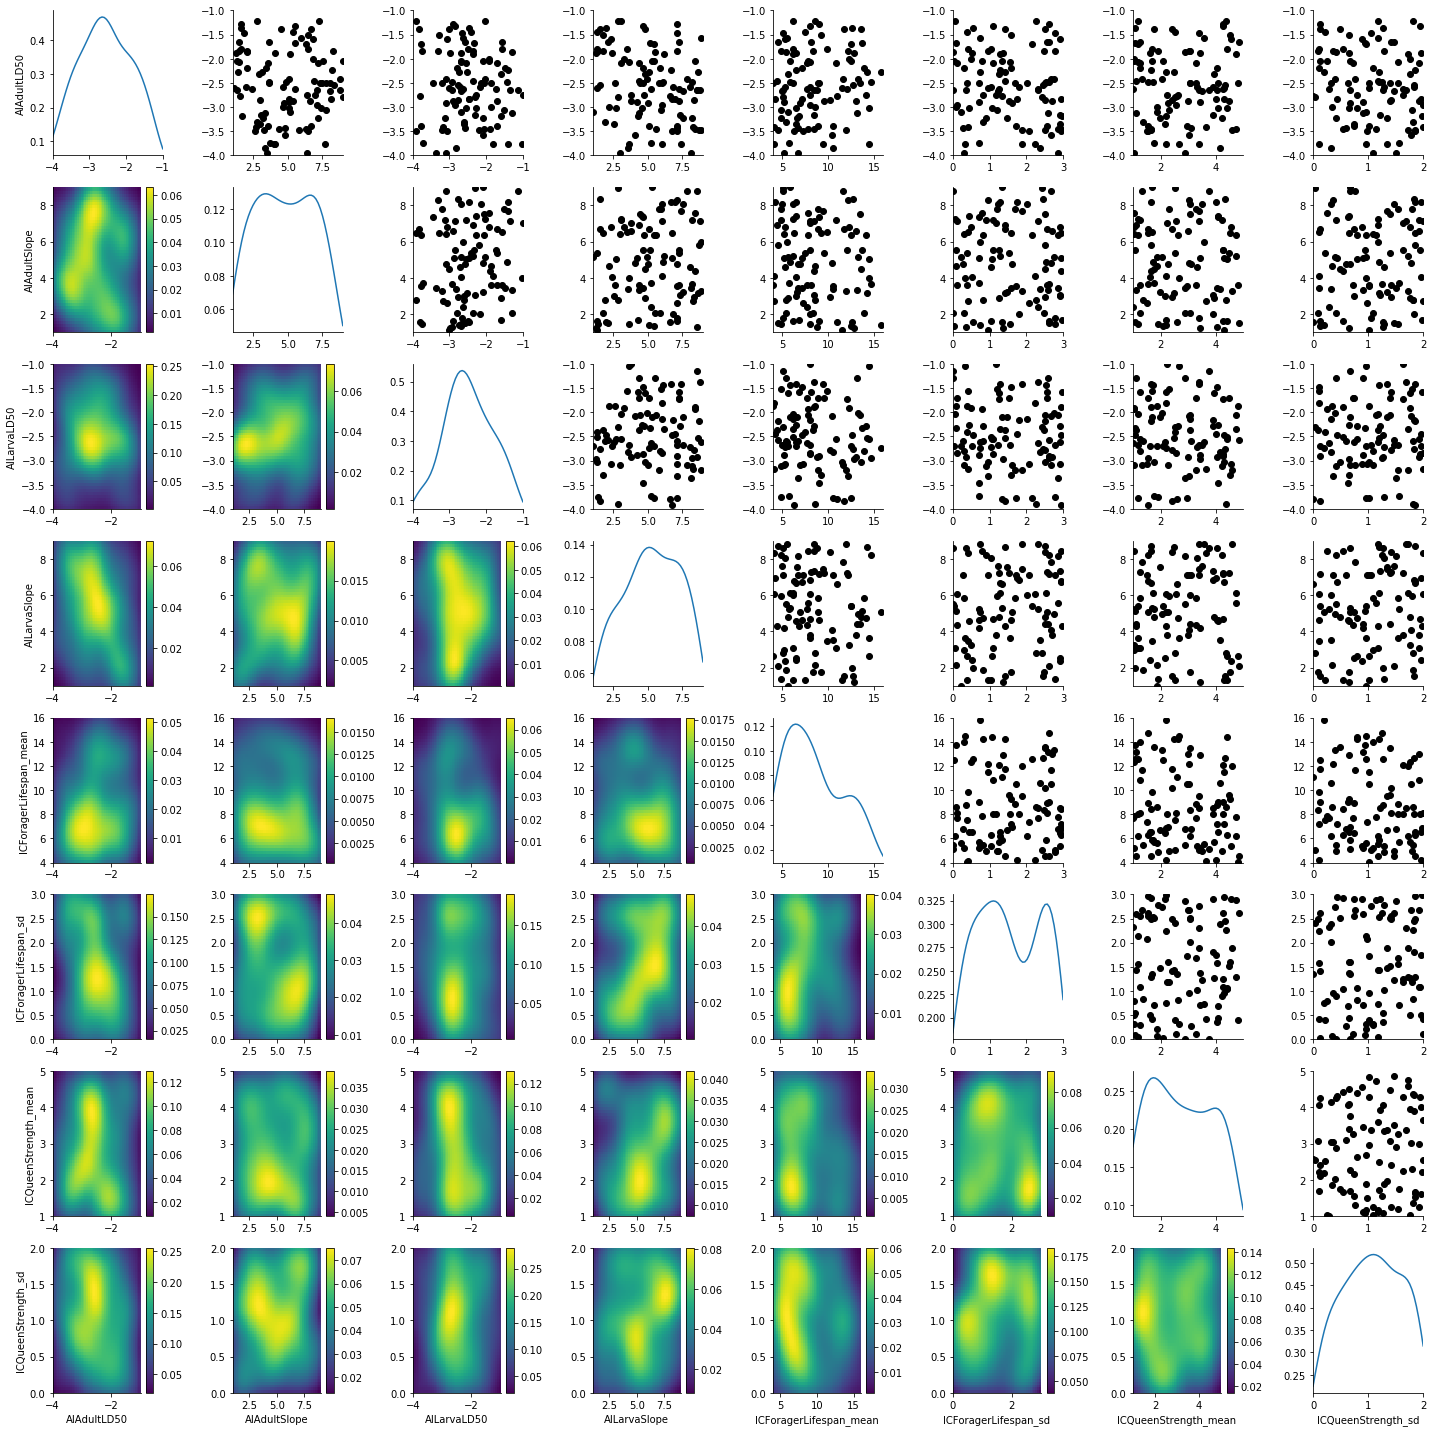

In [18]:
df, w = history.get_distribution(m=0, t=0)
plot_kde_matrix(df, w, limits=limits);

### Visualize from a stored run

In [16]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_19.db"))
history = History(db_path)
history.id = 15

df, w = history.get_distribution(m=0, t=3)


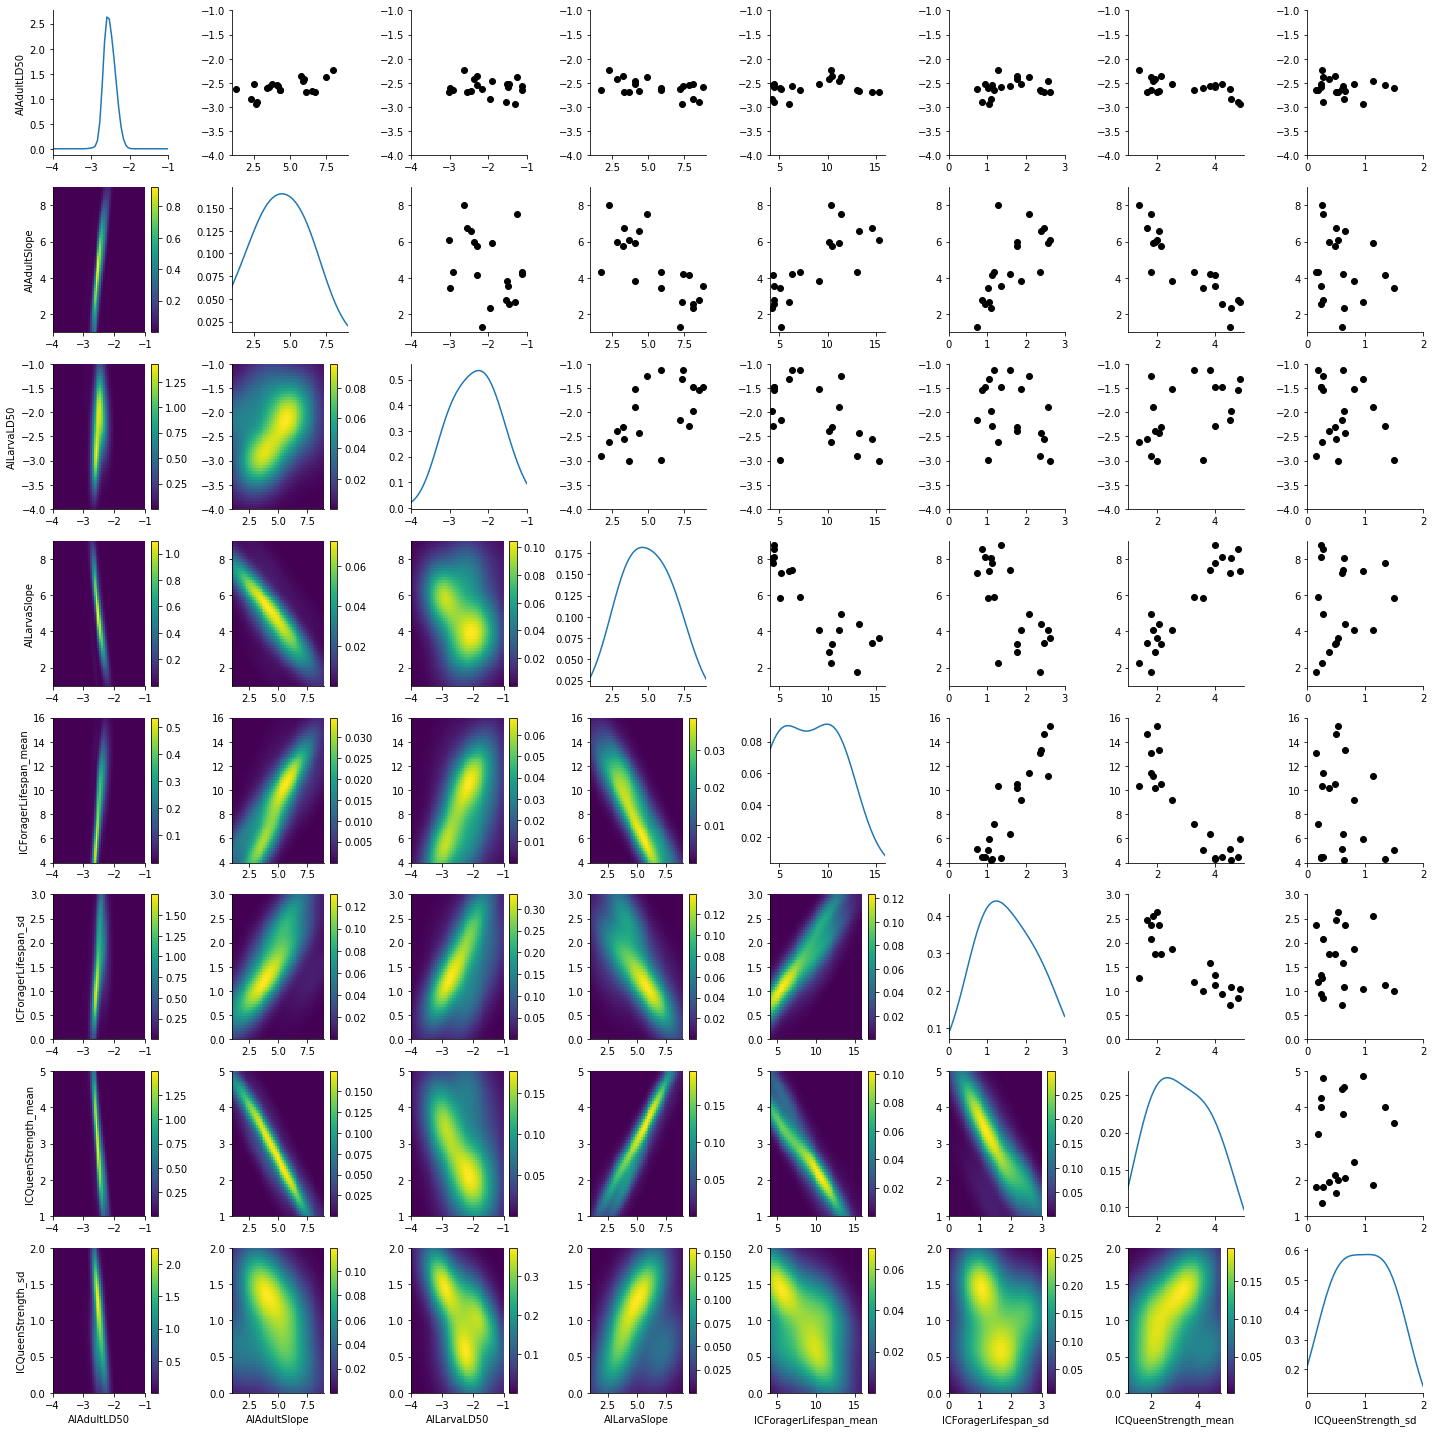

In [6]:
plot_kde_matrix(df, w, limits=limits);

In [14]:
df

name,AIAdultLD50,AIAdultSlope,AILarvaLD50,AILarvaSlope,ICForagerLifespan_mean,ICForagerLifespan_sd,ICQueenStrength_mean,ICQueenStrength_sd
id,,,,,,,,
49,-2.092330,7.947470,-3.170093,7.141028,10.644656,2.643069,1.964163,0.586244
50,-2.804825,6.717132,-2.537718,5.981953,11.433434,1.560162,1.073571,1.632222
51,-2.626961,5.357265,-1.838498,6.648010,5.334274,0.602930,3.841115,0.736608
52,-2.911014,6.405454,-2.941634,7.891848,8.708154,1.959689,2.529885,0.905749
53,-3.156953,6.612881,-2.909453,3.516911,10.265014,0.674173,1.540254,1.142640
54,-3.388129,5.319674,-1.738380,6.704559,6.810448,0.696990,1.702337,0.377224
55,-2.509704,2.751256,-2.802042,4.431692,5.112919,1.214438,3.137567,0.805517
56,-3.217255,7.778915,-2.412713,3.086443,10.125579,0.434898,1.543278,0.281893
57,-2.486020,2.776310,-3.377100,3.486863,5.213986,1.998924,3.250143,0.866294


In [15]:
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-19 11:14:15.830089,0,0.000000,1
1,0,2018-11-19 11:21:07.715991,18,73171.648266,10
2,1,2018-11-19 11:25:43.344963,27,64799.859093,10


In [16]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-19 09:48:44.237618, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-11-19 10:16:00.313808, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-11-19 10:47:32.331211, end_time=None)>,
 <ABCSMC(id=4, start_time=2018-11-19 10:55:29.405699, end_time=None)>,
 <ABCSMC(id=5, start_time=2018-11-19 10:58:12.539482, end_time=2018-11-19 11:04:46.744872)>,
 <ABCSMC(id=6, start_time=2018-11-19 11:14:13.248036, end_time=2018-11-19 11:25:44.451251)>,
 <ABCSMC(id=7, start_time=2018-11-19 11:34:52.601518, end_time=None)>,
 <ABCSMC(id=8, start_time=2018-11-19 11:37:28.154822, end_time=None)>,
 <ABCSMC(id=9, start_time=2018-11-19 12:02:46.222771, end_time=None)>,
 <ABCSMC(id=10, start_time=2018-11-19 12:49:26.291791, end_time=2018-11-19 13:05:23.635283)>,
 <ABCSMC(id=11, start_time=2018-11-19 13:14:18.630738, end_time=2018-11-19 13:56:03.907584)>]

In [17]:
np.median(df['AIAdultLD50']), np.mean(df['AIAdultLD50'])

(-2.7158927318699972, -2.7732147727309466)

In [18]:
np.median(df['AILarvaLD50']), np.mean(df['AILarvaLD50'])

(-2.669880061446067, -2.478545472579086)